# Analyzing COVID-19 Papers

In this challenge, we will continue with the topic of COVID pandemic, and focus on processing scientific papers on the subject. There is [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) with more than 7000 (at the time of writing) papers on COVID, available with metadata and abstracts (and for about half of them there is also full text provided).

A full example of analyzing this dataset using [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) cognitive service is described [in this blog post](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). We will discuss simplified version of this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Getting the Data

First, we need get the metadata for CORD papers that we will be working with.

**NOTE**: We do not provide a copy of the dataset as part of this repository. You may first need to download the [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) file from [this dataset on Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Registration with Kaggle may be required. You may also download the dataset without registration [from here](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), but it will include all full texts in addition to metadata file.

We will try to get the data directly from online source, however, if it fails, you need to download the data as described above. Also, it makes sense to download the data if you plan to experiment with it further, to save on waiting time.

> **NOTE** that dataset is quite large, around 1 Gb in size, and the following line of code can take a long time to complete! (~5 mins)

In [2]:
#df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
df = pd.read_csv("../../../largedata/metadata.csv.zip", compression='zip')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../../../largedata/metadata.csv.zip'

In [3]:
# testing bc the to_date time below isn't working
# "time data "2008" doesn't match format "%Y-%m-%d",
#at position 252."
df['publish_time'][250:256]

NameError: name 'df' is not defined

We will now convert publication date column to `datetime`, and plot the histogram to see the range of publication dates.

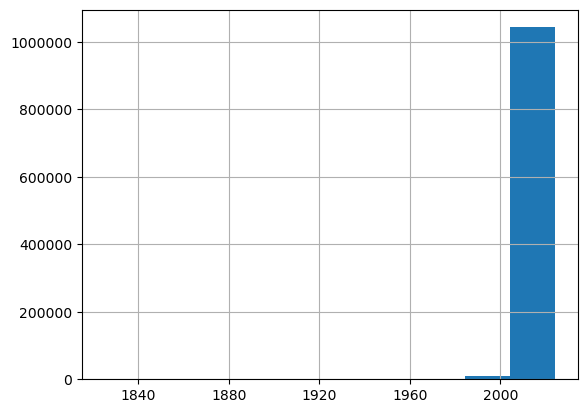

In [4]:
# mixed format because of the funky rows with only the year as date
df['publish_time'] = pd.to_datetime(df['publish_time'], format='mixed')
df['publish_time'].hist()
# so turns out the le6 at the top left means scientific notation.
# I don't want that, so thank you reddit
# https://www.reddit.com/r/learnpython/comments/el4vbx/how_to_remove_scientific_notation_from_a/
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

Interestingly, there are coronavirus-related papers that date back to 1880!

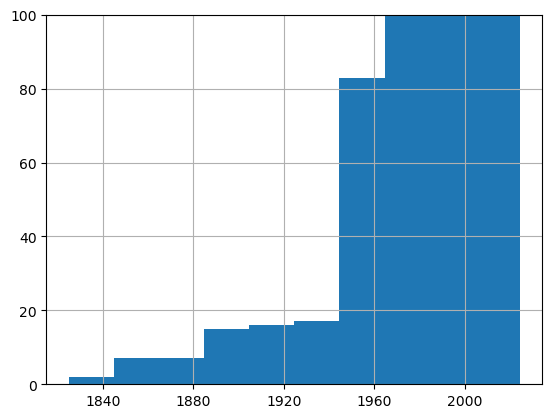

In [5]:
# okay but you can't actually see any information from 1880 so I'm
#changing the y-axis scale so you can actually see stuff
#https://stackoverflow.com/questions/3777861/how-to-set-the-axis-limits
df['publish_time'] = pd.to_datetime(df['publish_time'], format='mixed')
df['publish_time'].hist()
plt.gca().set_ylim([0, 100]) #btw gca means get (the) current axis
plt.show()

## Structured Data Extraction

Let's see what kind of information we can easily extract from abstracts. One thing we might be interested in is to see which treatment strategies exist, and how they evolved over time. To begin with, we can manually compile the list of possible medications used to treat COVID, and also the list of diagnoses. We then go over them and search corresponding terms in the abstracts of papers.

In [6]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


We have added a bunch of columns to our dataframe that contain number of times a given medicine/diagnosis is present in the abstract. 

> **Note** that we add space to the beginning of the word when looking for a substring. If we do not do that, we might get wrong results, because *chloroquine* would also be found inside substring *hydroxychloroquine*. Also, we force conversion of abstracts column to `str` to get rid of an error - try removing `str` and see what happens.

To make working with data easier, we can extract the sub-frame with only medication counts, and compute the accumulated number of occurrences. This gives is the most popular medication: 

In [7]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine  11157
3           remdesivir  10680
2          tocilizumab   7914
8              heparin   5563
1          chloroquine   5222
7        dexamethasone   5110
4         azithromycin   4352
5            lopinavir   4315
9          favipiravir   3358
10  methylprednisolone   2346
6            ritonavir   1151

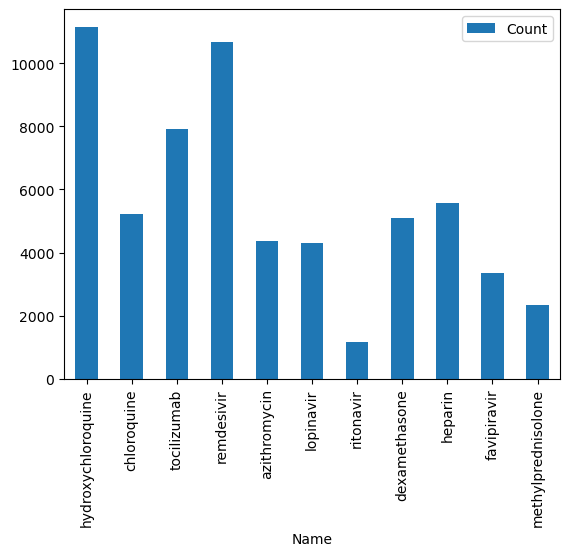

In [8]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Looking for Trends in Treatment Strategy

In the example above we have `sum`ed all values, but we can also do the same on a monthly basis:

In [9]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab   
publish_time publish_time                                                 
2020         1                           3885         1976         1911  \
             2                              0           19            0   
             3                             46           73            5   
             4                            186          236           49   
             5                            450          188          158   
             6                            381          149          243   
             7                            379          176          204   
             8                            313          115          175   
             9                            318          124          188   
             10                           311           96          210   
             11                           267           66          169   
             12                           254          108          228   
2021         1                           2467          882         2165   
             2                            165           66          184   
             3                            175           86          189   
             4                            200           71          129   
             5                            152           55          139   
             6                            144           30          146   
             7                            115           45           96   

                           remdesivir  azithromycin  lopinavir  ritonavir   
publish_time publish_time                                                   
2020         1                   2280          1226       1549        403  \
             2                      3             3         18         11   
             3                     29            12         52         16   
             4                    122            69        113         13   
             5                    209           128        134         41   
             6                    186           110        132         18   
             7                    174           108        138         29   
             8                    173           148         93         24   
             9                    190            90         97         28   
             10                   227            93        126         39   
             11                   202            77        106         27   
             12                   267            98         75         30   
2021         1                   2877          1072        932        216   
             2                    180            90         76          9   
             3                    301            89        101         18   
             4                    167            89         60         13   
             5                    182            71         56         22   
             6                    180            75         47         14   
             7                    252            83         52          4   

                           dexamethasone  heparin  favipiravir   
publish_time publish_time                                        
2020         1                       598     1027          730  \
             2                         1        3           12   
             3                         3       18           11   
             4                        14       80           48   
             5                        12       93           48   
             6                        48       84           30   
             7                        58      116           56   
             8                        56       96           46   
             9                        90      113           46   
             10                      101      117           82   
             11                       84 

This gives us a good picture of treatment strategies. Let's visualize it!

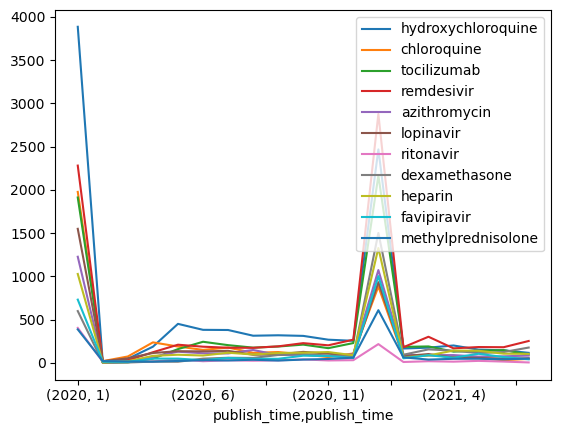

In [10]:
dfmt.plot()
plt.show()

An interesting observation is that we have huge spikes at two locations: January, 2020 and January, 2021. It is caused by the fact that some papers do not have a clearly specified data of publication, and they are specified as January of the respective year.

To make more sense of the data, let's visualize just a few medicines. We will also "erase" data for January, and fill it in by some medium value, in order to make nicer plot:
  - this erasing technique I think would be super useful in other places too.

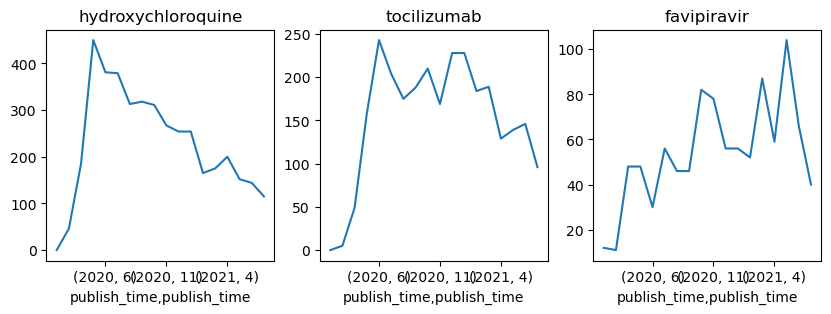

In [11]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

Observe how popularity of hydroxychloroquine was on the rise in the first few months, and then started to decline, while number of mentions of favipiravir shows stable rise. Another good way to visualize relative popularity is to use **stack plot** (or **area plot** in Pandas terminology):

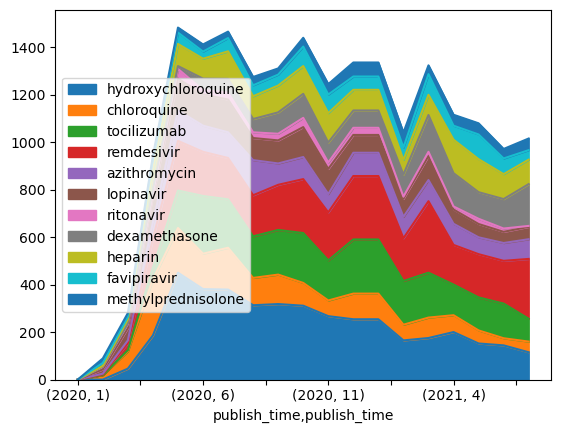

In [12]:
dfmt.plot.area()
plt.show()

Even further, we can compute relative popularity in percents:

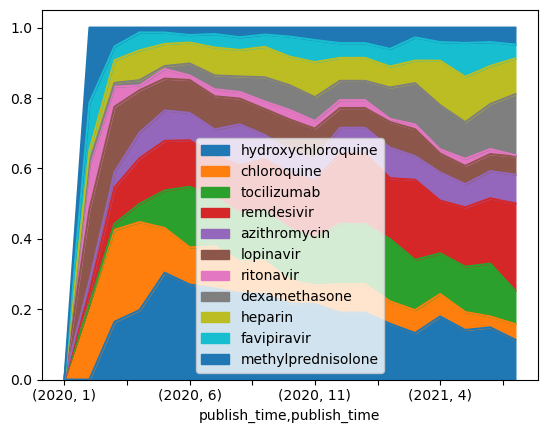

In [13]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()


## Computing Medicine-Diagnosis Correspondence

One of the most interesting relationships we can look for is how different diagnoses are treated with different medicines. In order to visualize it, we need to compute **co-occurence frequency map**, which would show how many times two terms are mentioned in the same paper.

Such a map is essentially a 2D matrix, which is best represented by **numpy array**. We will compute this map by walking through all abstracts, and marking entities that occur there:

In [14]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [15]:
m

array([[5470., 2585.,  812., 2381.,  387., 3036., 1081.],
       [2376., 1381.,  258., 1077.,   90., 1555.,  408.],
       [2738., 1007.,  833., 1343.,  236., 1333.,  678.],
       [4284., 2804.,  720., 2076.,  241., 2677.,  817.],
       [2163.,  928.,  476., 1066.,  180., 1032.,  481.],
       [2244., 1239.,  424.,  976.,  122., 1495.,  406.],
       [ 594.,  429.,   87.,  301.,   23.,  409.,  123.],
       [2164.,  919.,  521., 1113.,  180., 1019.,  463.],
       [2035.,  877.,  428.,  999.,  137.,  996.,  365.],
       [1257.,  791.,  250.,  565.,   55.,  804.,  173.],
       [1008.,  476.,  399.,  574.,  100.,  582.,  205.]])

One of the ways to visualize this matrix is to draw a **heatmap**:
  - ngl a heatmap looks super cool

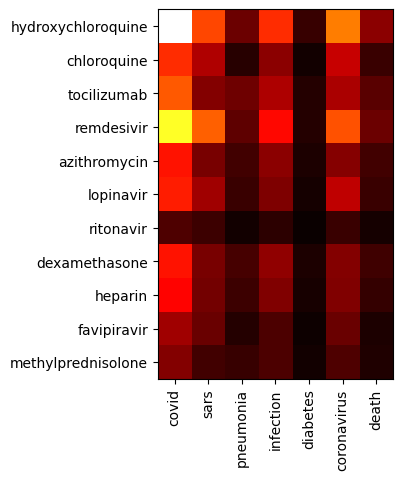

In [16]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

However, even better visualization can be done using so-called **Sankey** diagram! `matplotlib` does not have built-in support for this diagram type, so we would have to use [Plotly](https://plotly.com/python/) as described [in this tutorial](https://plotly.com/python/sankey-diagram/).

To make plotly sankey diagram, we need to build the following lists:
* List `all_nodes` of all nodes in the graph, which will include both medications and diagnosis
* List of source and target indices - those lists would show, which nodes go to the left, and which to the right part of the diagram
* List of all links, each link consisting of:
   - Source index in the `all_nodes` array
   - Target index 
   - Value indicating strength of the link. This is exactly the value from our co-occurence matrix.
   - Optionally color of the link. We will make an option to highlight some of the terms for clarity

Generic code to draw sankey diagram is structured as a separate `sankey` function, which takes two lists (source and target categories) and co-occurence matrix. It also allows us to specify the threshold, and omit all links that are weaker than that threshold - this makes the diagram a little bit less complex. 

!!! I don't know why the sankey diagram is (hopefully soon to be was) not showing up but I will try to make a sankey diagram with less data to see if I can identify what the problem is !!!

In [17]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

considering the above code is literally copy pasted from [the plotly docs](https://plotly.com/python/sankey-diagram/) and I still have the same no-show sankey diagram, the issue is probably in the environment.

from [this](https://github.com/ricklupton/ipysankeywidget/issues/12) git discussion it might be because of issues surrounding my ipywidgets installation? Will try njwhite's suggestion in the docker README / this notebook's terminal.

okay so apparently you will also need to use the ipysankeywidget library so let me test using [their example code](https://nbviewer.org/github/ricklupton/ipysankeywidget/blob/master/examples/Simple%20example.ipynb)

In [19]:
from ipysankeywidget import SankeyWidget

# instance of SankeyWidget
links = [
    {'source': 'start', 'target': 'A', 'value': 2},
    {'source': 'A', 'target': 'B', 'value': 2},
    {'source': 'C', 'target': 'A', 'value': 2},
    {'source': 'A', 'target': 'C', 'value': 2},
]
w = SankeyWidget(links=links, margins=dict(top=0, bottom=0, left=50, right=100))

# display widget
w

# at least there's an error? smells like PROGRESS
# pickup HERE with
#   - https://github.com/ricklupton/ipysankeywidget

SankeyWidget(links=[{'source': 'start', 'target': 'A', 'value': 2}, {'source': 'A', 'target': 'B', 'value': 2}…

In [20]:
def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])
# I don't know why nothing is showing up, COME BACK TO THIS

## Conclusion

You have seen that we can use quite simple methods to extract information from non-structured data sources, such as text. In this example, we have taken the existing list of medications, but it would be much more powerful to use natural language processing (NLP) techniques to perform entity extraction from text. In [this blog post](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) we describe how to use cloud services for entity extraction. Another option would be using Python NLP libraries such as [NLTK](https://www.nltk.org/) - an approach for extracting information from text using NLTK is described [here](https://www.nltk.org/book/ch07.html).

## Challenge

Continue to research the COVID paper data along the following lines:

1. Build co-occurrence matrix of different medications, and see which medications often occur together (i.e. mentioned in one abstract). You can modify the code for building co-occurrence matrix for medications and diagnoses.
1. Visualize this matrix using heatmap.
1. As a stretch goal, you may want to visualize the co-occurrence of medications using [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [This library](https://pypi.org/project/chord/) may help you draw a chord diagram.
1. As another stretch goal, try to extract dosages of different medications (such as **400mg** in *take 400mg of chloroquine daily*) using regular expressions, and build dataframe that shows different dosages for different medications. **Note**: consider numeric values that are in close textual vicinity of the medicine name.

### co-ocurrence matrix of different medications
Build co-occurrence matrix of different medications, and see which medications often occur together (i.e. mentioned in one abstract). You can modify the code for building co-occurrence matrix for medications and diagnoses.

In [21]:
# I literally just changed all "diagnoses" to "medications", hope it works
meds = np.zeros((len(medications),len(medications)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(medications):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    meds[j,i] += 1

In [22]:
meds

array([[6313., 1657.,  684., 1224., 1593., 1194.,  284.,  305.,  144.,
         545.,  117.],
       [1657., 2980.,  219.,  743.,  506.,  655.,  200.,  123.,   34.,
         338.,   18.],
       [ 684.,  219., 3105.,  594.,  304.,  396.,   89.,  316.,  110.,
         216.,  175.],
       [1224.,  743.,  594., 5124.,  393.,  911.,  246.,  821.,  147.,
         680.,  100.],
       [1593.,  506.,  304.,  393., 2542.,  449.,  106.,  188.,   93.,
         196.,   89.],
       [1194.,  655.,  396.,  911.,  449., 2610.,  547.,  156.,   48.,
         455.,   71.],
       [ 284.,  200.,   89.,  246.,  106.,  547.,  767.,   45.,   23.,
         113.,   16.],
       [ 305.,  123.,  316.,  821.,  188.,  156.,   45., 2766.,  142.,
         129.,  208.],
       [ 144.,   34.,  110.,  147.,   93.,   48.,   23.,  142., 2867.,
          49.,   57.],
       [ 545.,  338.,  216.,  680.,  196.,  455.,  113.,  129.,   49.,
        1545.,   42.],
       [ 117.,   18.,  175.,  100.,   89.,   71.,   16.,  20

so! there's not really a huge red flag yet, will proceed with the 

### heatmap

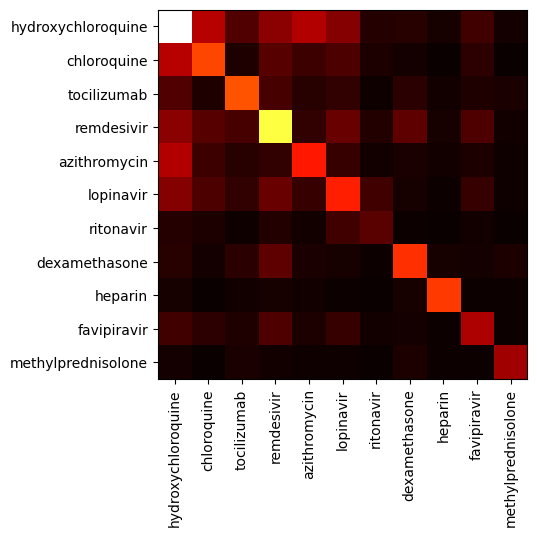

In [23]:
plt.imshow(meds,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(medications)))
ax.set_xticklabels(medications,rotation=90)
plt.show()

*note I don't really get why there are different levels of co-occurence with different types of medicines with themselves but I'm just gonna guess that's because of how often they show up at all (ex. hydroxychloroquine shows up a lot more than nitonavir in papers). 
  - actually that theory lines up with the data (and bar plot we made of the data) really well so that's another point towards the frequency of medicines theory

but this is kind of basic + I'm not at all confident I'll be able to do literally any of the remaining tasks for this challenge so let's make this heatmap better!

1: show only the upper/lower triangle
  - the same set of labels (data?) is used for x-axis and y-axis so you really only need the top or bottom half of squares because the information is reflected over that diagonal in the middle.

2: annotate squares
  - okay maybe this will make it too cramped but I just want to try it

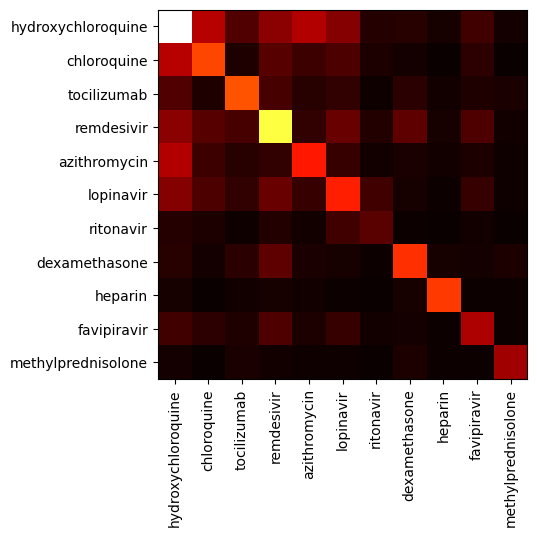

In [24]:
# everyone say thank you to the author (R. K. Rishi) for creating the exact tutorial I wanted
#https://www.tutorialspoint.com/plotting-only-the-upper-lower-triangle-of-a-heatmap-in-matplotlib
# also here bc I needed more explanation whoops
#https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap

# so basically this just changes the data below the diagonal to 0(?) which has a white value 
#so it looks like that bottom triangle is gone.

# btw my plot is 11x11
plt.imshow(meds,interpolation='nearest',cmap='hot')

# you already created your data earlier
# np.tri() "creates an array at and below the given diagonal (k, with the middle one being 0,
#diagonals below: k < 0, above: k > 0) with 1's and 0's elsewhere. But the opposite of this 
#would work better with how my axis are arranged 
mask = np.tri(meds.shape[0], k=-1)
meds = np.ma.array(meds, mask=mask)

# mostly labelling of axis
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(medications)))
ax.set_xticklabels(medications,rotation=90)

#plt.imshow(meds, interpolation="nearest", cmap='hot')
plt.show()

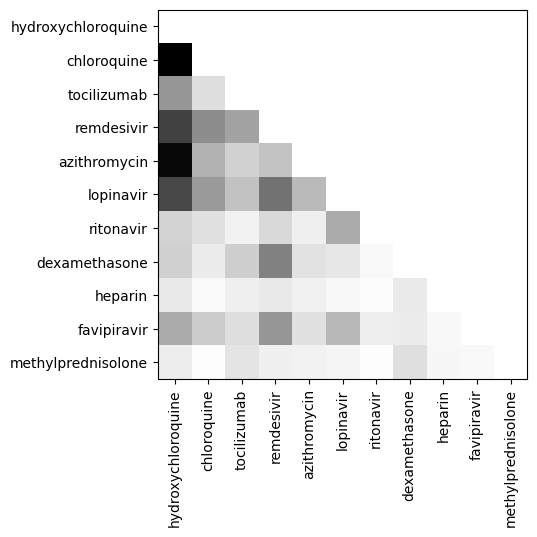

In [31]:
from matplotlib import cm as CM
import matplotlib as mpl

# btw my plot is 11x11
# wait I got it okay what if I just make it so there's only
#data below the main diagonal and then input that into the 
#heatmap
#https://www.geeksforgeeks.org/numpy-triu-python/

# gotta change zero values to white (not black) so it looks better
#https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
#cmap = mpl.colormaps['hot']
#cmap.set_bad('k') # default value is 'k'
# can't figure out how set_bad works

# nah screw it I'll just make the cmap one that has a zero value of
#white so it'll make sense that the upper triangle is white. 
#Because technically it does make sense the upper triangle is black
#because it is all zero (aka removed)
cmap = mpl.colormaps['binary']

# tril just returns the lower triangle, you don't actually need the
#middle diagonal because we aren't really looking for how often
#they correspond with themselves.
plt.imshow(np.tril(meds, -1),interpolation='nearest',cmap=cmap)

# mostly labelling of axis
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(medications)))
ax.set_xticklabels(medications,rotation=90)

#plt.imshow(meds, interpolation="nearest", cmap='hot')
plt.show()

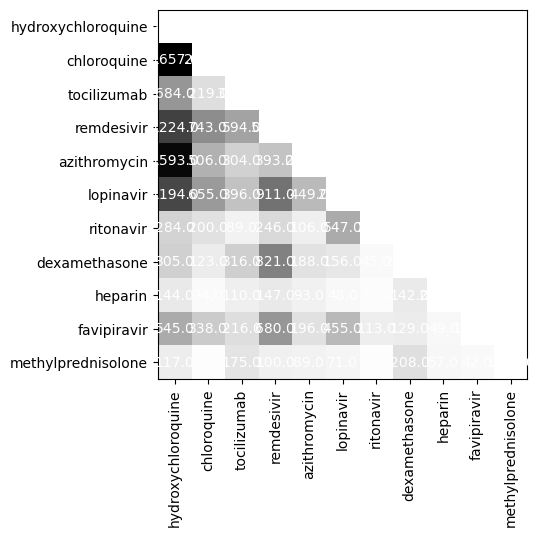

In [30]:
# okay last thing to try is the annotation
# I will use the bottom triangle code

# zero value is white
cmap = mpl.colormaps['binary']

# tril just returns the lower triangle
plt.imshow(np.tril(meds, -1),interpolation='nearest',cmap=cmap)

# labelling of axis and adding ticks
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(medications)))
ax.set_xticklabels(medications,rotation=90)

# annotations
#https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
# Loop over data dimensions and create text annotations.
for i in range(len(medications)):
    for j in range(len(medications)):
        text = ax.text(j, i, np.tril(meds)[i, j],
                       ha="center", va="center", color="w")

plt.show()

so it's way too cramped with annotations but the non-annotaed bottom triangle with taht colourscheme is very cool.

I feel like I was supposed to mention the correlations at some point so I'll mention now, in descending levels of correlation (lower means less correlation, but all are still somewhat notable)
  - 1: *hydroxycholorquine* and *chloroquine*, *hydroxychloroquine* and *azithromycin*
  - 2: *hydroxycholorquine* and *remdesivir*, *hydroxycholorquine* and *lopinavir*
  - 3: *remdesivir* and *lopinavir*, *remdesivir* and *dexamethasone*
It gets a little indecipherable after that point but there are still also others that have correlation beyond these 6.

### chord diagram
As a stretch goal, you may want to visualize the co-occurrence of medications using [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram). [This library](https://pypi.org/project/chord/) may help you draw a chord diagram.

so turns out you need to upgrade to higher than free membership to use plotapi's chord, thus we are going to try using [holoviews](https://pypi.org/project/holoviews/): it may not be as pretty, but it's *open source*.

In [48]:
# I think this is an example
#https://www.holoviews.org/reference/elements/matplotlib/Chord.html#chord

import holoviews as hv

from holoviews import dim, opts
from bokeh.sampledata.les_mis import data

hv.extension('matplotlib')
hv.output(fig='svg', size=200)

links = pd.DataFrame(data['links'])
print(links.head(3))

hv.Chord(links)

# I'm gonna cry how did this work
#okay so it only partially works because it turns out even this uncoloured diagram is supposed to be 
#interactve but it just isn't

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

   source  target  value
0       1       0      1
1       2       0      8
2       3       0     10


:Chord   [source,target]   (value)

In [49]:
# second example from the same source
# here are the docs for more help
#https://www.holoviews.org/reference_manual/holoviews.element.html#holoviews.element.Chord

nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
nodes.data.head()

chord = hv.Chord((links, nodes)).select(value=(5, None))

# so turns out this applies a lot of "options" and is what makes this chord diagram different
#from the above one. Deal with this after creating the diagram with the actual data.
chord.opts(opts.Chord(cmap='Category20', edge_color=dim('source').astype(str), labels='name', node_color=dim('index').astype(str)))

:Chord   [source,target]   (value)

Time to try it with my own information. I will likely need more help from the docs to add colour because I do not understand that part at all but I can try it simply with nodes and links.

In [64]:
# remake meds bc I screwed it up with np.tril()
meds = np.zeros((len(medications),len(medications)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(medications):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    meds[j,i] += 1

There seem to be issues with nodes and links being dicts so I will try [this guy's method](https://coderzcolumn.com/tutorials/data-science/how-to-plot-chord-diagram-in-python-holoviews), who actually outlines a bit more in detail but nodes and links should actually be like to try and fix things.

In [73]:
# testing df with meds
meds
medications
testmedsdf = pd.DataFrame(meds, columns=medications)
testmedsdf

hydroxychloroquine  chloroquine  tocilizumab  remdesivir  azithromycin   
0               6313.0       1657.0        684.0      1224.0        1593.0  \
1               1657.0       2980.0        219.0       743.0         506.0   
2                684.0        219.0       3105.0       594.0         304.0   
3               1224.0        743.0        594.0      5124.0         393.0   
4               1593.0        506.0        304.0       393.0        2542.0   
5               1194.0        655.0        396.0       911.0         449.0   
6                284.0        200.0         89.0       246.0         106.0   
7                305.0        123.0        316.0       821.0         188.0   
8                144.0         34.0        110.0       147.0          93.0   
9                545.0        338.0        216.0       680.0         196.0   
10               117.0         18.0        175.0       100.0          89.0   

    lopinavir  ritonavir  dexamethasone  heparin  favipiravir   
0      1194.0      284.0          305.0    144.0        545.0  \
1       655.0      200.0          123.0     34.0        338.0   
2       396.0       89.0          316.0    110.0        216.0   
3       911.0      246.0          821.0    147.0        680.0   
4       449.0      106.0          188.0     93.0        196.0   
5      2610.0      547.0          156.0     48.0        455.0   
6       547.0      767.0           45.0     23.0        113.0   
7       156.0       45.0         2766.0    142.0        129.0   
8        48.0       23.0          142.0   2867.0         49.0   
9       455.0      113.0          129.0     49.0       1545.0   
10       71.0       16.0          208.0     57.0         42.0   

    methylprednisolone  
0                117.0  
1                 18.0  
2                175.0  
3                100.0  
4                 89.0  
5                 71.0  
6                 16.0  
7                208.0  
8                 57.0  
9                 42.0  
10              1438.0

In [74]:
# lifting linking code from the attempted sankey diagram for links here

def chordd(cat1, cat2, matrix, threshold=0, h1=[], h2=[]):
    # relevant for nodes
    all_nodes = cat1 + cat2 

    # relevant for links
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    # relevant for links
    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if matrix[i,j]>threshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(matrix[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')
                
    # Define nodes
    node = hv.Dataset(pd.DataFrame(meds, columns=medications))

    ####### still need to fix link
    
    # Add links
    #I do not know if links are supposed to be like this but we
    #will find out
    link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    )

    fig = hv.Chord((link, nodes)).select(value=(5, None))

    return fig

chordd(medications,medications,meds,500,h2=[0])

DataError: None of the available storage backends were able to support the supplied data format. DictInterface raised following error:

 Dictionary data not understood, should contain a column per dimension or a mapping between key and value dimension values.

DictInterface expects tabular data, for more information on supported datatypes see http://holoviews.org/user_guide/Tabular_Datasets.html

In [ ]:
# YOU ARE HERE
#    * I think you should try the chord diagram
#    * you can try dosages but honestly I don't even understand what it's asking for